# CLIP

In this exercise, you'll learn how you can use pretrained vision-language models for transfer learning as well as zero-shot classification and retrieval.

You'll need to install the python packages `open_clip_torch` and `tqdm`, e.g. with `pip install open_clip_torch tqdm`.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import open_clip
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from tqdm import tqdm

## Dataset

For this exercise, we're going to use a small dataset with about 500 images which are sorted into 6 different categories. You can download the dataset from https://nc.mlcloud.uni-tuebingen.de/index.php/s/KmPbJaZ7gB7Fbp9 (about 130MB) and unzip it in the current directory. This should give you a new sub directory `image_dataset`. Now we load the data, split it into a training and a validation part and look at a few examples from the validation set.

In [27]:
dataset = ImageFolder('image_dataset', transform=ToTensor())

generator = torch.Generator().manual_seed(42)
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100], generator=generator)

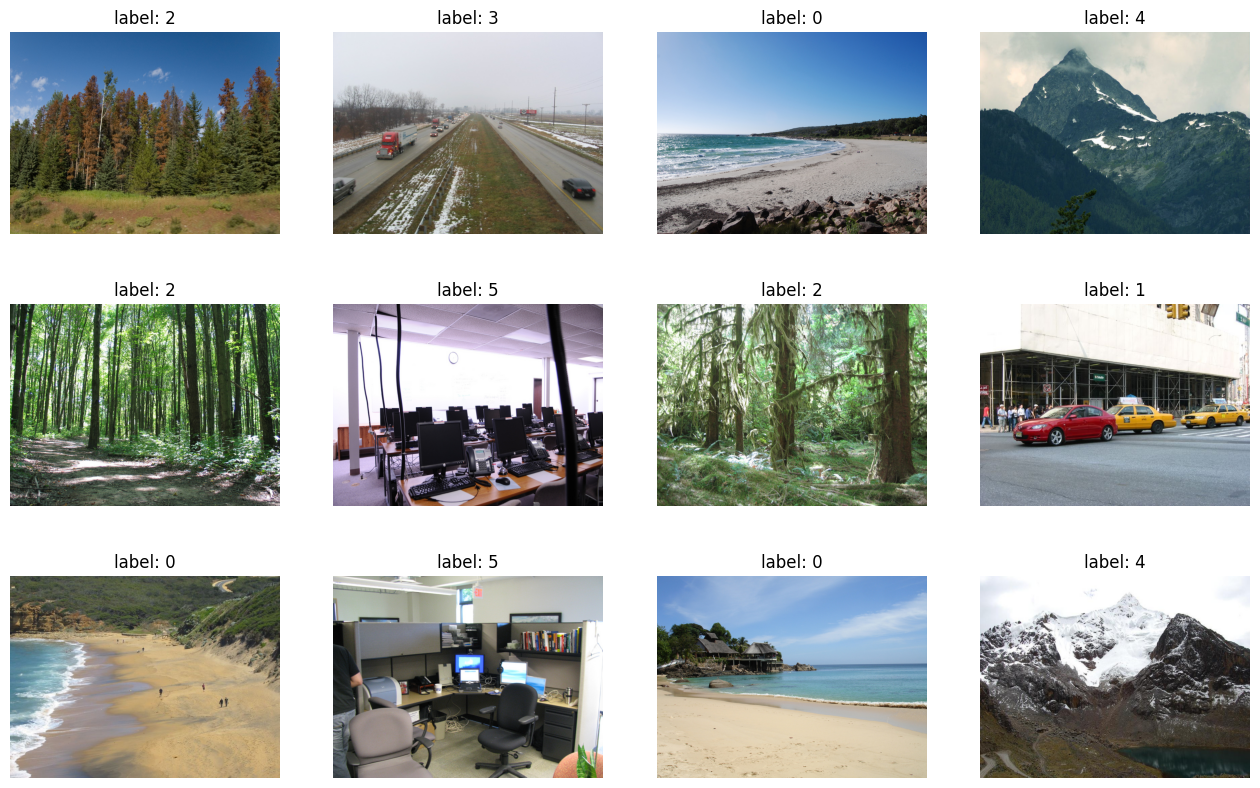

In [28]:
rst = np.random.RandomState(43)
f, axes = plt.subplots(3, 4, figsize=(16, 10))

for ax in axes.flatten():
    image, label = validation_dataset[rst.randint(len(validation_dataset))]
    ax.imshow(image.numpy().transpose(1, 2, 0))
    ax.set_title(f"label: {label}")
    ax.set_axis_off()

## Linear Classification

First, we want to try to classify the images with a simple linear classifier, which we implement in pytorch and train using crossentropy.

In [57]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    
)

val_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [58]:
class LinearClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # we first downsample by a factor of 10 to make things a bit simpler
        self.pool1 = torch.nn.AvgPool2d((10, 10))
        self.linear1 = torch.nn.Linear(60 * 80 * 3, 6)
    
    def forward(self, x):
        x = self.pool1(x)
        x = x.view(-1, 60 * 80 * 3)
        x = self.linear1(x)
        return x
    
model = LinearClassifier()

We train the classifier for crossentropy. We additionally employ a learning rate decay schedule: After certain numbers of epochs, the learning rate will be decayed by a factor of 10. You have to decide about optimizer, initial learning rate and decay schedule

In [59]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.7, weight_decay=1e-2, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20])  # choose two decay milestones

In [60]:
# number of epochs to train the model
n_epochs = 25

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        #print(data.shape)
        #print(target.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
    lr_scheduler.step()
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.097754
Epoch: 2 	Training Loss: 1.450368
Epoch: 3 	Training Loss: 1.362269
Epoch: 4 	Training Loss: 1.171156
Epoch: 5 	Training Loss: 1.126179
Epoch: 6 	Training Loss: 1.030438
Epoch: 7 	Training Loss: 0.929489
Epoch: 8 	Training Loss: 0.834676
Epoch: 9 	Training Loss: 0.765678
Epoch: 10 	Training Loss: 0.709269
Epoch: 11 	Training Loss: 0.455452
Epoch: 12 	Training Loss: 0.420009
Epoch: 13 	Training Loss: 0.414649
Epoch: 14 	Training Loss: 0.413246
Epoch: 15 	Training Loss: 0.413356
Epoch: 16 	Training Loss: 0.405217
Epoch: 17 	Training Loss: 0.406316
Epoch: 18 	Training Loss: 0.399250
Epoch: 19 	Training Loss: 0.398394
Epoch: 20 	Training Loss: 0.398334
Epoch: 21 	Training Loss: 0.383410
Epoch: 22 	Training Loss: 0.381038
Epoch: 23 	Training Loss: 0.380339
Epoch: 24 	Training Loss: 0.380491
Epoch: 25 	Training Loss: 0.380088


In [61]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.987157

Test Accuracy of     0: 78% (15/19)
Test Accuracy of     1: 58% (10/17)
Test Accuracy of     2: 66% (10/15)
Test Accuracy of     3: 70% (12/17)
Test Accuracy of     4: 52% (10/19)
Test Accuracy of     5: 69% ( 9/13)

Test Accuracy (Overall): 66% (66/100)


Mit torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True) war der Training Loss ab Epoche 56 stets 0. -> Overfitting

Mit torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True) war der Training Loss 0.000012 mit 60 Epochen, aber der Test Loss 14.821574 und die Test Accuracy 60% (60/100).

Mit torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.7, weight_decay=1e-3, nesterov=True), 30 Epochen und milestones 12 und 23 war der Training Loss 0.286328, Test Loss 4.657504 und Test Accuracy (Overall): 64% (64/100).

Mit torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.7, weight_decay=1e-2, nesterov=True), 25 Epochen und milestones 10 und 20 war der Training Loss 0.380088 und der Test Loss 0.987157 und Test Accuracy (Overall): 66% (66/100).

#### Exercise 3.1

Try to find good choices for optimizer, initial learning rate and decay schedule. Does the linear classifier reach a good performance on the validation set? If not, what kind of reasons might be responsible for this?

To find good choices for the optimizer, initial learning rate, and decay schedule, we experimented with different configurations. The linear classifier did not reach a very high performance on the validation set. The best configuration we found was using `torch.optim.SGD` with a learning rate of 0.001, momentum of 0.7, weight decay of 1e-2, and a learning rate decay schedule with milestones at epochs 10 and 20. This configuration resulted in a training loss of 0.380088 and a test loss of 0.987157, with an overall test accuracy of 66%.

The linear classifier's performance might be limited due to the simplicity of the model and the complexity of the dataset. The images in the dataset might contain features that are not easily separable by a linear classifier. Additionally, the small size of the dataset could lead to overfitting, where the model performs well on the training data but poorly on the validation data.

In summary, the linear classifier's performance is constrained by its simplicity and the dataset's complexity. More advanced models or techniques, such as transfer learning with a pretrained model, might yield better results.

### Linear Classifier on CLIP embedding

In this section, we'll employ transfer learning: Instead of learning a model from scratch, we'll put a linear readout on top of a pretrained CLIP vision encoder. We'll keep the CLIP model fixed and only train the linear readout.

In [62]:
# download and load the CLIP model. Depending on your internet connection, the download will take some time, but it need to be done only once.
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model.eval()

# the tokenizer is a preprocessing for the text encoder that we'll need later.
tokenizer = open_clip.get_tokenizer('ViT-B-32')

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [87]:
# for the CLIP model, we need a different preprocessing, which conveniently has been provided by `create_model_and_transforms`.
# This preprocessing transforms and crops the image to the required size for the model
# Because of this, we need to build dataset and data loaders again.

dataset = ImageFolder('image_dataset', transform=preprocess)
generator = torch.Generator().manual_seed(42)  # set seed to make split deterministic
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100], generator=generator)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    
)

val_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [88]:
class CLIPClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = clip_model
        # freeze the CLIP parameters
        for parameter in self.backbone.parameters():
            parameter.requires_grad = False
        self.readout = torch.nn.Linear(512, 6)
    
    def forward(self, x):
        # we don't want to train the CLIP model
        with torch.no_grad():
            embedding = self.backbone.encode_image(x)
        
        logits = self.readout(embedding)
        return logits
    
    def train(self, mode=True):
        super().train(mode=mode)
        # keep backbone in evalm mode
        self.backbone.eval()
    
model = CLIPClassifier()

In [69]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,9,12]) # adapt

In [70]:
# number of epochs to train the model
n_epochs = 15 # adapt

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        #print(data.shape)
        #print(target.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        #print(data)
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
    lr_scheduler.step()
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.036268
Epoch: 2 	Training Loss: 0.020166
Epoch: 3 	Training Loss: 0.017316
Epoch: 4 	Training Loss: 0.033440
Epoch: 5 	Training Loss: 0.031783
Epoch: 6 	Training Loss: 0.011803
Epoch: 7 	Training Loss: 0.008407
Epoch: 8 	Training Loss: 0.009508
Epoch: 9 	Training Loss: 0.010951
Epoch: 10 	Training Loss: 0.010896
Epoch: 11 	Training Loss: 0.011004
Epoch: 12 	Training Loss: 0.011218
Epoch: 13 	Training Loss: 0.011242
Epoch: 14 	Training Loss: 0.011263
Epoch: 15 	Training Loss: 0.011277


In [71]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.013719

Test Accuracy of     0: 100% (19/19)
Test Accuracy of     1: 100% (17/17)
Test Accuracy of     2: 100% (15/15)
Test Accuracy of     3: 100% (17/17)
Test Accuracy of     4: 100% (19/19)
Test Accuracy of     5: 100% (13/13)

Test Accuracy (Overall): 100% (100/100)


#### Exercise 3.2

Select optimizer, initial learning rate and decay schedule to train the linear readout on top of the CLIP model. What kind of performance do you get? Is the result in some sense surprising? How is performance on validation and training set related to the results of the linear classifier trained in 3.1? How do you explain the differences? What kind of differences did you notice in the training dynamcis compared to the purely linear model above?

*put your answers here*

## CLIP with zero shot text based classification

One of the special properties of CLIP models is that they are not just image models, but a vision language model. This facilitates zero shot classification using text queries. This example demonstrates how you can compute scores (logits) for different text queries given an image

In [89]:
text = tokenizer(["a diagram", "a dog", "a cat"])
image = train_dataset[0][0].unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_logits = (100.0 * image_features @ text_features.T)
    text_probabilities = text_logits.softmax(dim=-1)
    print(text_probabilities)

/tmp/ipykernel_142015/315541603.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


tensor([[0.4938, 0.4909, 0.0153]])


Use this example to construct a text based classifier. The `text_logits` from the example are essentially what used to be the model output previously. Since we're now in a *zero-shot setting*, there is no training involved and we only need to the evaluation loop.

In [102]:
# these are the text queries that characterize the different classes in the dataset. You'll need to find good queries yourself.
queries = [
    'sea and sand',
    'mixture of buildings, cars, streets and trees',
    'forest',
    'highway',
    'mountain',
    'office',
]

text = tokenizer(queries)
text_features = clip_model.encode_text(text)
text_features /= text_features.norm(dim=-1, keepdim=True)

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # TODO: compute text_logits as in the example in the previous cell
    # note that the text features are already computed because they
    # don't change from image to image
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(data)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    text_logits = (100.0 * image_features @ text_features.T)
    
    # calculate the loss
    loss = criterion(text_logits, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(text_logits, 1) # text_logits statt "output"
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
        

/tmp/ipykernel_142015/2708973681.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Test Loss: 0.019015

Test Accuracy of     0: 100% (19/19)
Test Accuracy of     1: 100% (17/17)
Test Accuracy of     2: 100% (15/15)
Test Accuracy of     3: 100% (17/17)
Test Accuracy of     4: 100% (19/19)
Test Accuracy of     5: 100% (13/13)

Test Accuracy (Overall): 100% (100/100)


#### Exercise 3.3

Complete the above snippet for the text-based classifier and make it work. Try to find good text queries for the six different classes. What kind of performance do you get? How did you find the queries? What are advantages and disadvantages compared to the linear classifier?

Ergebnis:

Für label 0, 2, 4 und 5 haben die offensichtlichen queries wie sie oben zu sehen sind gut funktioniert. Für 1 und 3 war es etwas schwieriger passende queries zu finden, da sie manchmal schwierig zu unterscheiden sind, da sie ähnliche oder teilweise gleiche Elemente enthalten. Der erste Versuch war "city" für 1 und "streets" für 3. In den Bildern von 1 sind jedoch auch Straßen, wodurch das Modell die Kategorien nicht gut auseinanderhalten konnte. Für 1 ergab sich eine Test Accuracy von 58% und für 3 sogar 0%.  
Durch Betrachtung einiger Bilder von 1 und 3 konnten die queries besser spezifiziert werden. Mit den queries "mixture of buildings, cars, streets and trees" für 1 und "american highway" für 3 konnten sehr gute Ergebnisse erzielt werden. Bei allen labels außer 3 lag die Test Accuracy bei 100%. Bei 3 lag sie bei 94%, was eine Overall Test Accuracy von 99% ergibt.  
Ändert man das query für 3 zu "highway" wird auch hier eine Test Accuracy von 100% erzielt. Das Adjektiv "american" traf somit nicht auf alle Bilder zu.

Ein wichtiger Vorteil von CLIP ist seine Zero-Shot-Fähigkeit. Im Gegensatz zu einem linearen classifier kann CLIP direkt auf neue, zuvor ungesehene Klassen angewendet werden, ohne dass explizite Trainingsdaten für jede einzelne Klasse notwendig sind. Dies ist besonders nützlich, wenn die Zahl der Klassen hoch ist oder neue Klassen hinzukommen.  
Ein weitere Vorteil ist die Flexibilität bei den Text queries. Diese werden intuitiver für Menschen (z.B. Wald statt Bäume) und können sich besser anpassen als festgeschriebene labels beim linearen classifier. Das führt wiederum zur Herausforderung die queries eindeutig zu definieren. Dies wurde im Beispiel zuvor bei den Kategorien 1 und 3 verdeutlicht.  
Noch ein Nachteil von CLIP ist der Rechenaufwand durch das Training sowohl mit Bild als auch mit Text. Ein linearer classifier ist in der Regel effizienter und kann für ein bestimmtes Datenset optimiert werden. Auch kann besser nachvollzogen werden, wie das Modell Entscheidungen trifft und speziell darauf reagiert werden.  
Insgesamt hängt es also von der Aufgabenstellung und dem Datenset ab, welche Wahl besser ist und muss individuell entschieden werden.

### Text based Image Retrieval

Image retrieval is the task of finding the best matching image given a certain query that here will be formulated as text. Because no training is needed anymore, we'll now use the full dataset

In [ ]:
raw_dataset = ImageFolder('image_dataset')  # we'll need this later to display the original images
dataset = ImageFolder('image_dataset', transform=preprocess)

To do so, we first need to build a database of CLIP embeddings for all candidate images.

In [ ]:
# We compute normalized images features for each image in the training dataset
# and concatenate them into a (N_images, N_features) dimensional torch tensor that then can be used for fast image querying.
embeddings = []
labels = []

for image, label in tqdm(dataset):
    image_tensor = image.unsqueeze(0)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    # save image features
    embeddings.append(image_features)
    labels.append(label)

# build "embedding database"
embeddings = torch.concat(embeddings)

This is the image that we want to find in the dataset:

In [ ]:
plt.imshow(raw_dataset[100][0])
plt.axis('off');

To find images matching a text query, instead of matching one image against multiple texts, we'll now match many images against one text. By sorting the images according to the returned CLIP scores, we can display the most promising matches.

In [ ]:
query = 'some image description'  # fill in

text = tokenizer(query)

# compute probabilities for each image given the text query
# this is very similar to the snippets above, but be
# careful: now we're not interested in probabilites for each text query
# but in probabilities for each image. Hence there will be subtle changes
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = TODO
    image_logits = TODO
    image_probabilities = TODO
    
sorted_indices = np.argsort(image_probabilities.numpy())
sorted_indices = sorted_indices[::-1]
    
f, axes = plt.subplots(1, 5, figsize=(16, 4))
for index, ax in zip(sorted_indices, axes):
    #print(index)
    image = raw_dataset[index][0]
    ax.imshow(image)
    ax.set_axis_off()
    ax.set_title(f"probability: {image_probabilities[index].numpy():.0%}")


#### Excercise 3.4

Complete the code above and find a text query that returns the target image as best matching candidate. How well can you separate it from other images? With other words, how high can you drive the assigned probability for the correct image? Descrie how you found the query that you used in the end.

*put your answers here*